# Importing, subsetting, and saving routines to generate all data files found in this repository

This notebook will take ~10hrs to run, and the SSMI has to be subsetted manually to get around a server timeout issue

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

from matplotlib import pyplot as plt
%matplotlib inline

Initialize the spatial and temporal limits for this analysis - will be applied to all datasets

In [2]:
lat_min, lat_max = 65.479474, 68.708048
lon_min, lon_max = -169.259880, -160.007140

start_date = pd.datetime(2003,1,1)
end_date = pd.datetime(2018,11,1)
ddts = pd.date_range(start=start_date,end=end_date) #"daily-date-times"

------------

# MODIS SST

Pulling MODIS sst data from https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/contents.html

Filename conventions found at: ftp://podaac-ftp.jpl.nasa.gov/allData/modis/L3/docs/modis_fileinfo.txt

In [3]:
#create list of MODIS SST OpenDAP urls for all days in ddts
url_day = []
url_night = []
for day in ddts:
    yearday = day.strftime('%j')
    year = day.strftime('%Y')
    url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{yearday}/A{year}{yearday}.L3m_DAY_SST_sst_4km.nc')
    url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{yearday}/A{year}{yearday}.L3m_DAY_NSST_sst_4km.nc')
 

In [19]:
#Write a for loop to generate urls. Iterate through years and days 1-365, then throw a conditional at the end of it for the leap years. 
url_day = []
url_night = []
years = np.arange(2003, 2019)
for year in years:
    #we have 4 cases for the days: 1-digit, 2-digit, 3-digit, and leap year
    for day in np.arange(1,10):   
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/00{day}/A{year}00{day}.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/00{day}/A{year}00{day}.L3m_DAY_NSST_sst_4km.nc')
    
    for day in np.arange(10,100):
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/0{day}/A{year}0{day}.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/0{day}/A{year}0{day}.L3m_DAY_NSST_sst_4km.nc')
    
    for day in np.arange(100,366):
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{day}/A{year}{day}.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/{day}/A{year}{day}.L3m_DAY_NSST_sst_4km.nc')
    
    if year==2004 or year==2008 or year==2012 or year==2016:
        url_day.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/366/A{year}366.L3m_DAY_SST_sst_4km.nc')
        url_night.append(f'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/{year}/366/A{year}366.L3m_DAY_NSST_sst_4km.nc')

In [75]:
#DAYTIME IMPORTING
#import and slice the first one before getting into a for loop
sst_mod_day = xr.open_dataset(url_day[0]).sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max)) #latitude variable is monotonically decreasing from 90 down.
#add new time dimensional coordinate
startTime = pd.to_datetime(sst_mod_day.attrs['time_coverage_start'])
endTime = pd.to_datetime(sst_mod_day.attrs['time_coverage_end'])
midTime = (endTime - startTime)/2 + startTime
sst_mod_day = sst_mod_day.assign_coords(time=midTime)
sst_mod_day = sst_mod_day.expand_dims('time')

#now do the rest of them in a for loop
from tqdm import tqdm #progress bar for sanity
for url in tqdm(url_day[1:]):
    #import and slice
    ds_day = xr.open_dataset(url).sel(lat=slice(lat_max,lat_min), lon=slice(lon_min,lon_max)) #latitude variable is monotonically decreasing from 90 down.
    #add new time dimensional coordinate
    startTime = pd.to_datetime(ds_day.attrs['time_coverage_start'])
    endTime = pd.to_datetime(ds_day.attrs['time_coverage_end'])
    midTime = (endTime - startTime)/2 + startTime
    ds_day = ds_day.assign_coords(time=midTime)
    ds_day = ds_day.expand_dims('time')    
    
    sst_mod_day = xr.auto_combine([sst_mod_day,ds_day],concat_dim='time')

sst_mod_day
    

100%|██████████| 5783/5783 [4:24:36<00:00,  3.68s/it]


<xarray.Dataset>
Dimensions:   (eightbitcolor: 256, lat: 77, lon: 222, rgb: 3, time: 5784)
Coordinates:
  * lat       (lat) float32 68.68749 68.64583 68.604164 68.56249 68.52083 ...
  * lon       (lon) float32 -169.22917 -169.1875 -169.14584 -169.10417 ...
  * time      (time) datetime64[ns] 2003-01-01T13:30:05 2003-01-02T13:35:05 ...
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    palette   (time, rgb, eightbitcolor) int8 91 10 118 99 9 -117 112 7 -85 ...
    sst       (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    qual_sst  (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...

In [77]:
sst_mod_day.to_netcdf(path='sst_modis_day.nc')

### All Importing Above can be skipped by running the below line

In [4]:
sst_mod_day = xr.open_dataset('sst_modis_day.nc')
sst_mod_day

<xarray.Dataset>
Dimensions:   (eightbitcolor: 256, lat: 77, lon: 222, rgb: 3, time: 5784)
Coordinates:
  * lat       (lat) float32 68.68749 68.64583 68.604164 68.56249 68.52083 ...
  * lon       (lon) float32 -169.22917 -169.1875 -169.14584 -169.10417 ...
  * time      (time) datetime64[ns] 2003-01-01T13:30:05 2003-01-02T13:35:05 ...
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    palette   (time, rgb, eightbitcolor) int8 ...
    sst       (time, lat, lon) float32 ...
    qual_sst  (time, lat, lon) float32 ...

### Making the files yearly so that they're small enough for github:

In [7]:
sst_mod_day_yearly = sst_mod_day.groupby('time.year')
for key, group in sst_mod_day_yearly:
    group.to_netcdf(path=f'sst_modis_day_{key}.nc')

In [4]:
modis_files = []
for year in np.arange(2003,2019):
    modis_files.append(f'sst_modis_day_{year}.nc')
modis_files

['sst_modis_day_2003.nc',
 'sst_modis_day_2004.nc',
 'sst_modis_day_2005.nc',
 'sst_modis_day_2006.nc',
 'sst_modis_day_2007.nc',
 'sst_modis_day_2008.nc',
 'sst_modis_day_2009.nc',
 'sst_modis_day_2010.nc',
 'sst_modis_day_2011.nc',
 'sst_modis_day_2012.nc',
 'sst_modis_day_2013.nc',
 'sst_modis_day_2014.nc',
 'sst_modis_day_2015.nc',
 'sst_modis_day_2016.nc',
 'sst_modis_day_2017.nc',
 'sst_modis_day_2018.nc']

In [5]:
sst_mod_day = xr.open_mfdataset(modis_files)
sst_mod_day

<xarray.Dataset>
Dimensions:   (eightbitcolor: 256, lat: 77, lon: 222, rgb: 3, time: 5784)
Coordinates:
  * lat       (lat) float32 68.68749 68.64583 68.604164 68.56249 68.52083 ...
  * lon       (lon) float32 -169.22917 -169.1875 -169.14584 -169.10417 ...
  * time      (time) datetime64[ns] 2003-01-01T13:30:05 2003-01-02T13:35:05 ...
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    palette   (time, rgb, eightbitcolor) int8 dask.array<shape=(5784, 3, 256), chunksize=(365, 3, 256)>
    sst       (time, lat, lon) float32 dask.array<shape=(5784, 77, 222), chunksize=(365, 77, 222)>
    qual_sst  (time, lat, lon) float32 dask.array<shape=(5784, 77, 222), chunksize=(365, 77, 222)>

--------------

# Reynolds SST and Sea Ice Concentration

Data Access: https://www.ncei.noaa.gov/thredds/catalog/OisstBase/NetCDF/AVHRR/catalog.html

In [5]:
#create list of Reynolds SST OpenDAP urls for all days in ddts
url_rey = []
for day in ddts:
    yearmonth = day.strftime('%Y%m')
    yearmonthday = day.strftime('%Y%m%d')
    url_rey.append(f'http://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/AVHRR/{yearmonth}/avhrr-only-v2.{yearmonthday}.nc')

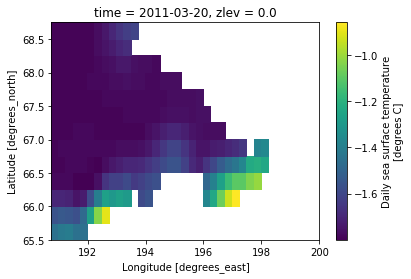

In [6]:
reynolds = xr.open_dataset(url_rey[3000])
reynolds.sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360)).sst.plot() #lon values are 0-360 in this dataset

In [ ]:
sst_rey = xr.open_dataset(url_rey[0]).sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360)) #lon values are 0-360 in this dataset

from tqdm import tqdm #progress bar for sanity

for url in tqdm(url_rey[1:]):
    ds_rey = xr.open_dataset(url).sel(lat=slice(lat_min,lat_max), lon=slice((lon_min+360)%360, (lon_max+360)%360))   
    sst_rey = xr.auto_combine([sst_rey,ds_rey])
    
sst_rey
    

In [26]:
sst_rey

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 37, time: 5783, zlev: 1)
Coordinates:
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 65.625 65.875 66.125 66.375 66.625 66.875 67.125 ...
  * lon      (lon) float32 190.875 191.125 191.375 191.625 191.875 192.125 ...
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 2003-01-03 ...
Data variables:
    sst      (time, zlev, lat, lon) float32 -1.13 -1.11 -1.09 -1.03 ...
    anom     (time, zlev, lat, lon) float32 0.04 0.049999997 0.07 0.12 0.21 ...
    err      (time, zlev, lat, lon) float32 0.13 0.13 0.13 0.13 0.13 nan nan ...
    ice      (time, zlev, lat, lon) float32 0.85999995 0.85999995 0.82 0.83 ...

In [33]:
sst_rey.to_netcdf(path='sst_reynolds.nc')

### All Importing Above can be skipped by running the below line

In [ ]:
sst_rey = xr.open_dataset('sst_reynolds.nc')

-------------

## SSM/I Sea Ice Concentration

In [4]:
url_ssmi = ['http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2003',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2004',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2005',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2006',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2007',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2008',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2009',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2010',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2011',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2012',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2013',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2014',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2015',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2016',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2017',
            'http://icdc.cen.uni-hamburg.de/thredds/dodsC/ssmi_asi_icecon_arc2018']

In [5]:
si = xr.open_mfdataset(url_ssmi)

/opt/conda/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'sea_ice_area_fraction' has multiple fill values {101, 103}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [6]:
ssmi = si.where(
    si.latitude>lat_min).where(
    si.latitude<lat_max).where(
    si.longitude>(lon_min+360)%360).where( #lon values are 0-360
    si.longitude<(lon_max+360)%360).sel(x=slice(118,155),
                                        y=slice(518,551))  #the where commands mask the dataset, slicing x and y keeps us from carrying all the masked points along with us
ssmi

<xarray.Dataset>
Dimensions:                (time: 5783, x: 37, y: 33)
Coordinates:
    latitude               (y, x) float32 66.106 66.206 66.306 66.405 66.505 ...
    longitude              (y, x) float32 199.472 199.354 199.234 199.114 ...
  * time                   (time) datetime64[ns] 2003-01-01T12:00:00 ...
Dimensions without coordinates: x, y
Data variables:
    sea_ice_area_fraction  (time, y, x) float32 dask.array<shape=(5783, 33, 37), chunksize=(365, 33, 37)>
    land                   (time, y, x) float64 dask.array<shape=(5783, 33, 37), chunksize=(365, 33, 37)>
Attributes:
    Conventions:               CF-1.5
    long_name:                 Sea-ice concentration as observed by SSM/I
    short_name:                PSI-F13-Concentration
    producer_agency:           IFREMER
    producer_institution:      CERSAT
    modification_institution:  CliSAP
    modification1:             5-day median filter
    modification2:             spatial and temporal interpolation
    time_r

Takes 3+ minutes to compute a single day:

In [10]:
with ProgressBar():
    ssmi_ex = ssmi.sea_ice_area_fraction.sel(time='2018-04-30').compute()

[########################################] | 100% Completed |  3min  5.0s


We'll save this single day to use as our example plot of spatial extent:

In [11]:
ssmi_ex.to_netcdf(path='ssmi_ex.nc') 

In [7]:
seaice = ssmi.sea_ice_area_fraction.chunk(chunks=(1,33,37))
seaice

<xarray.DataArray 'sea_ice_area_fraction' (time: 5783, y: 33, x: 37)>
dask.array<shape=(5783, 33, 37), dtype=float32, chunksize=(1, 33, 37)>
Coordinates:
    latitude   (y, x) float32 dask.array<shape=(33, 37), chunksize=(33, 37)>
    longitude  (y, x) float32 dask.array<shape=(33, 37), chunksize=(33, 37)>
  * time       (time) datetime64[ns] 2003-01-01T12:00:00 2003-01-02T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:  sea_ice_area_fraction
    long_name:      sea-ice concentration
    units:          percent

I did this year by year and saved each year independently - it was the only way to get the server to fulfill my requests without timing out:

In [16]:
with ProgressBar():
    seaice1y = seaice[5479:].mean(dim={'x','y'}).compute()
    
seaice1y

[########################################] | 100% Completed |  9.1s


<xarray.DataArray 'sea_ice_area_fraction' (time: 304)>
array([61.856823, 65.373604, 70.60626 , ...,  0.187919,  0.187919,  0.248322],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T12:00:00 2018-01-02T12:00:00 ...

In [18]:
seaice1y.to_netcdf(path='seaice18.nc')

Now I can reimport the yearly files as a multi-file dataset:

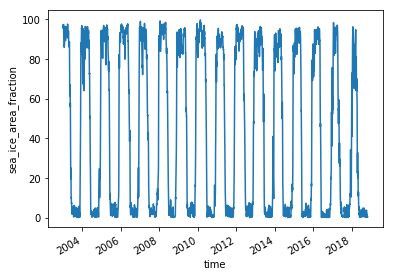

In [21]:
si_nc_list = ['seaice03.nc',
              'seaice04.nc',
              'seaice05.nc',
              'seaice06.nc',
              'seaice07.nc',
              'seaice08.nc',
              'seaice09.nc',
              'seaice10.nc',
              'seaice11.nc',
              'seaice12.nc',
              'seaice13.nc',
              'seaice14.nc',
              'seaice15.nc',
              'seaice16.nc',
              'seaice17.nc',
              'seaice18.nc']
seaice_all = xr.open_mfdataset(si_nc_list)
seaice_all.sea_ice_area_fraction.plot()

Then I went ahead and re-saved all the years together into one netCDF file:

In [22]:
seaice_all.to_netcdf(path='seaice_all.nc')